# Model Distillation with Pytorch

## 0. Choosing our "teacher" and "student" models

In [1]:
student = "distilbert-base-uncased"
teacher = "roberta-base"

## 1. Loading our SST-2 part of the GLUE dataset

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "sst2", split=["train[:30000]", "validation", "train[60000:62000]"])
bert_tokenizer    = AutoTokenizer.from_pretrained("distilbert-base-uncased")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

Found cached dataset glue (C:/Users/abhin/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
raw_datasets

[Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 30000
 }),
 Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 872
 }),
 Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 2000
 })]

In [4]:
from datasets import DatasetDict

In [5]:
raw_datasets = DatasetDict({
    "train": raw_datasets[0],
    "validation": raw_datasets[1],
    "test": raw_datasets[2]
})

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 2000
    })
})

In [7]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [8]:
raw_train_dataset[5]['sentence']

"that 's far too tragic to merit such superficial treatment "

In [9]:
raw_train_dataset[5]['label']

0

In [10]:
raw_train_dataset[5]['idx']

5

In [11]:
raw_train_dataset.features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

## 2. Preprocess

In [12]:
def bert_tokenize_function(example):
    return bert_tokenizer(example["sentence"], truncation=True)

def roberta_tokenize_function(example):
    return roberta_tokenizer(example["sentence"], truncation=True)

bert_tokenized_datasets    = raw_datasets.map(bert_tokenize_function, batched=True)
roberta_tokenized_datasets = raw_datasets.map(roberta_tokenize_function, batched=True)

bert_tokenized_datasets, roberta_tokenized_datasets

Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-bcec75499dbbfbe0.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-e07210e1dc5385ce.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-8d5efb1b02ba6ccf.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-672fe29dbcb5112e.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-4b8bc7ab2cdb38cc.arrow
Loading cached processed dataset at C:\Users\abhin\.cac

(DatasetDict({
     train: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 30000
     })
     validation: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 872
     })
     test: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 2000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 30000
     })
     validation: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 872
     })
     test: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 2000
     })
 }))

## 3. Preparing for Training

In [13]:
from transformers import DataCollatorWithPadding

bert_data_collator    = DataCollatorWithPadding(tokenizer=bert_tokenizer)
roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

In [14]:
bert_tokenized_datasets = bert_tokenized_datasets.remove_columns(["sentence", "idx"])
bert_tokenized_datasets = bert_tokenized_datasets.rename_column("label", "labels")
bert_tokenized_datasets.set_format("torch")
bert_tokenized_datasets["test"].column_names

['labels', 'input_ids', 'attention_mask']

In [15]:
roberta_tokenized_datasets = roberta_tokenized_datasets.remove_columns(["sentence", "idx"])
roberta_tokenized_datasets = roberta_tokenized_datasets.rename_column("label", "labels")
roberta_tokenized_datasets.set_format("torch")
roberta_tokenized_datasets["test"].column_names

['labels', 'input_ids', 'attention_mask']

In [16]:
from torch.utils.data import DataLoader

bert_train_dataloader = DataLoader(
    bert_tokenized_datasets["train"], shuffle=True, batch_size=20, collate_fn=bert_data_collator
)

bert_val_dataloader = DataLoader(
    bert_tokenized_datasets["validation"], batch_size=20, collate_fn=bert_data_collator
)

bert_eval_dataloader = DataLoader(
    bert_tokenized_datasets["test"], batch_size=20, collate_fn=bert_data_collator
)

In [17]:
roberta_train_dataloader = DataLoader(
    roberta_tokenized_datasets["train"], shuffle=True, batch_size=20, collate_fn=roberta_data_collator
)

roberta_eval_dataloader = DataLoader(
    roberta_tokenized_datasets["test"], batch_size=20, collate_fn=roberta_data_collator
)

In [18]:
for batch in bert_train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([20]),
 'input_ids': torch.Size([20, 32]),
 'attention_mask': torch.Size([20, 32])}

## 4. Loading "teacher" and "student" models 

In [19]:
# id2label, label2id dicts for the outputs for the model
labels = bert_tokenized_datasets["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [20]:
from transformers import AutoModelForSequenceClassification

# teacher model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# student model
student_model = AutoModelForSequenceClassification.from_pretrained(
    student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [21]:
import torch 

best_teacher_weight = torch.load('./teacher-best_weight/roberta-base-SST-2.pt')

In [22]:
teacher_model.load_state_dict(best_teacher_weight['model_state_dict'])

<All keys matched successfully>

In [23]:
outputs = teacher_model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.7142, grad_fn=<NllLossBackward0>) torch.Size([20, 2])


In [24]:
outputs = student_model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.7266, grad_fn=<NllLossBackward0>) torch.Size([20, 2])


In [25]:
from torch.optim import AdamW

teacher_optimizer = AdamW(teacher_model.parameters(), lr=6e-5)
student_optimizer = AdamW(student_model.parameters(), lr=6e-5)

In [26]:
from train_eval_func import set_lr_scheduler

num_epochs = 15
num_training_steps = num_epochs * len(bert_train_dataloader)

teacher_lr_scheduler = set_lr_scheduler(
    optimizer          = teacher_optimizer,
    num_training_steps = num_training_steps
)

student_lr_scheduler = set_lr_scheduler(
    optimizer          = student_optimizer,
    num_training_steps = num_training_steps
)
print(num_training_steps)

22500


## 5. Training Loop

In [27]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
teacher_model.to(device)
student_model.to(device)
device

device(type='cuda')

In [28]:
from train_eval_func import eval_loop, EarlyStopping

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import time
import evaluate

progress_bar = tqdm(range(num_training_steps))
temperature = 4
alpha=0.5
val_old_loss = float("Inf")
n_batches = len(bert_train_dataloader)
path = './student-best_weight/'

train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

time_per_epoch_hist = []

teacher_model.eval()
train_start = time.time() 
for epoch in range(num_epochs):
    start = time.time()
    accuracy_metric = evaluate.load("accuracy")
    student_model.train()
    
    total_loss = 0
    
    earlyStopping = EarlyStopping()
    
    ## b_batch --> data tokenized using Bert tokenizer
    ## r_batch --> data tokenized using Roberta tokenizer
    for b, (b_batch, r_batch) in enumerate(zip(bert_train_dataloader, roberta_train_dataloader)):
        b_batch = {k: v.to(device) for k, v in b_batch.items()}
        r_batch = {k: v.to(device) for k, v in r_batch.items()}
        
        # compute student output
        outputs_student = student_model(**b_batch)
        student_loss    = outputs_student.loss
        
        # for computing training accuracy at the end of epoch
        student_logits  = outputs_student.logits
        predictions = torch.argmax(student_logits, dim=-1)
        accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
        
        # compute teacher output
        with torch.no_grad():
            outputs_teacher = teacher_model(**r_batch)
        
        # assert size
        assert outputs_student.logits.size() == outputs_teacher.logits.size()
        
        # compute distillation loss and soften probabilities
        loss_function = nn.KLDivLoss(reduction="batchmean")
        loss_logits = (loss_function(
            F.log_softmax(outputs_student.logits / temperature, dim=-1),
            F.softmax(outputs_teacher.logits / temperature, dim=-1)) * (temperature ** 2))
        
        loss = alpha * student_loss + (1. - alpha) * loss_logits
        total_loss += float(loss)
        loss.backward()
        
        student_optimizer.step()
        student_lr_scheduler.step()
        student_optimizer.zero_grad()
        progress_bar.update(1)
    
    #### training loss and accuracy 
    avg_train_loss = total_loss / n_batches
    train_acc      = accuracy_metric.compute()
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc['accuracy'])
    
    #### validation training loss and accuracy 
    val_acc, val_loss = eval_loop(student_model, bert_val_dataloader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc['accuracy'])
    
    if val_loss < val_old_loss:
        val_old_loss = val_loss
        saveObject = {
            'epoch': epoch + 1,
            'batch': b + 1,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': student_optimizer.state_dict(),
            'lr_scheduler_state_dict': student_lr_scheduler.state_dict()
        }
        torch.save(saveObject, path + 'KD_roberta_distilbert-SST-2.pt')
    
    #### Display metrics
    print("<-----------------", "Epoch", epoch + 1, "----------------->")
    print(f"Loss: {round(avg_train_loss, 2)}, Accuracy: {train_acc['accuracy']}")
    print(f"Validation Loss: {round(val_loss, 2)}, Validation Accuracy: {val_acc['accuracy']}")
    
    total_time_per_epoch = time.time() - start
    print("Elapsed Time:", round(total_time_per_epoch, 4), "sec") 
    time_per_epoch_hist.append(total_time_per_epoch)
    
    #### Check early stopping
    if earlyStopping.checkCondition(val_loss):
        print(">>>>> Early stoppping callback <<<<<")
        break

total_train_time = time.time() - train_start
print("Total Training Time:", total_train_time, "sec")

  0%|          | 0/22500 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<----------------- Epoch 1 ----------------->
Loss: 2.48, Accuracy: 0.27986666666666665
Validation Loss: 0.68, Validation Accuracy: 0.7350917431192661
Elapsed Time: 177.1137 sec
<----------------- Epoch 2 ----------------->
Loss: 2.44, Accuracy: 0.38763333333333333
Validation Loss: 0.65, Validation Accuracy: 0.786697247706422
Elapsed Time: 177.6926 sec
<----------------- Epoch 3 ----------------->
Loss: 2.43, Accuracy: 0.4070666666666667
Validation Loss: 0.72, Validation Accuracy: 0.7970183486238532
Elapsed Time: 177.5051 sec
<----------------- Epoch 4 ----------------->
Loss: 2.43, Accuracy: 0.41313333333333335
Validation Loss: 0.72, Validation Accuracy: 0.7912844036697247
Elapsed Time: 175.5327 sec
<----------------- Epoch 5 ----------------->
Loss: 2.43, Accuracy: 0.4189333333333333
Validation Loss: 0.74, Validation Accuracy: 0.6720183486238532
Elapsed Time: 177.3548 sec
<----------------- Epoch 6 ----------------->
Loss: 2.43, Accuracy: 0.4063
Validation Loss: 0.82, Validation Accu

In [30]:
saveMetricObject = {
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "time_per_epoch_hist": time_per_epoch_hist,
    "total_train_time": total_train_time
}

torch.save(saveMetricObject, path + 'KD_roberta_distilbert-SST-2_training_hist.pt')

### Plotting Loss

In [31]:
from train_eval_func import plotLoss, plotAccuracy

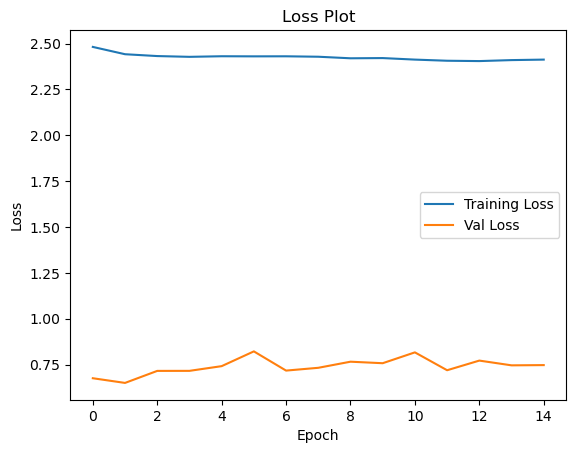

In [32]:
plotLoss(train_losses, val_losses, title="Loss Plot")

### Plotting Acccuracy

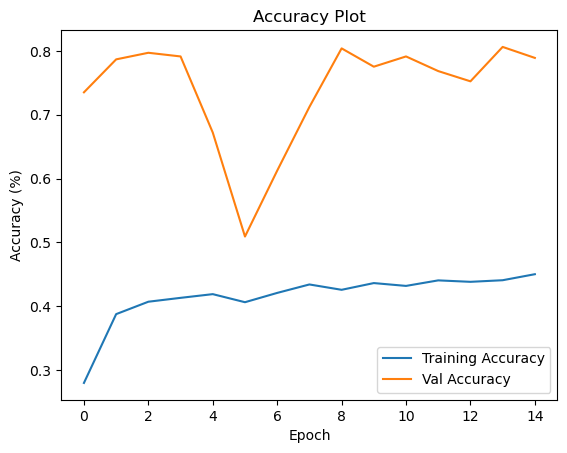

In [33]:
plotAccuracy(train_accs, val_accs, title="Accuracy Plot")

## 6. Evaluation

In [34]:
best_weight = torch.load(path + 'KD_roberta_distilbert-SST-2.pt')

In [35]:
student_model.load_state_dict(best_weight['model_state_dict'])

<All keys matched successfully>

### Teacher Model Accuracy

In [36]:
eval_loop(teacher_model, roberta_eval_dataloader, device)[0]['accuracy']

0.9295

### Student Model Accuracy

In [37]:
eval_loop(student_model, bert_eval_dataloader, device)[0]['accuracy']

0.815